In [ ]:
# default_exp modeling.core

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.core

> This module contains core custom models, loss functions, and a default layer group splitter for use in applying discriminiative learning rates to your huggingface models trained via fastai

In [ ]:
#export
import torch, nlp
from transformers import *

from fastai2.text.all import *
from fastai2.callback.hook import _print_shapes

from blurr.utils import *
from blurr.data.core import *

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Base splitter and model wrapper

In [ ]:
#export
def hf_splitter(m):
    """Splits the huggingface model based on various model architecture conventions"""
    model = m.hf_model if (hasattr(m, 'hf_model')) else m
    root_modules = list(model.named_children())
    top_module_name, top_module = root_modules[0]
    
    groups = L([ m for m_name, m in list(top_module.named_children()) ])
    groups += L([ m for m_name, m in root_modules[1:] ])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [ ]:
show_doc(hf_splitter)

<h4 id="hf_splitter" class="doc_header"><code>hf_splitter</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>hf_splitter</code>(**`m`**)

Splits the huggingface model based on various model architecture conventions

In [ ]:
#export
class HF_BaseModelWrapper(Module):
    def __init__(self, hf_model):
        super().__init__()
        self.hf_model = hf_model
        
        n_fwd_args = self.hf_model.forward.__code__.co_argcount
        self.hf_model_fwd_args = self.hf_model.forward.__code__.co_varnames[:n_fwd_args][1:]
        
    def forward(self, x): 
        for k in list(x): 
            if k not in self.hf_model_fwd_args: del x[k]         
                
        return self.hf_model(**x)

Note that `HF_baseModelWrapper` includes some nifty code for just passing in the things your model needs, as not all transformer architectures require/use the same information.

In [ ]:
#export
class HF_BaseModelCallback(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

We use a `Callback` for handling what is returned from the huggingface model ... "the huggingface model will return a tuple in outputs, with the actual predictions and some additional activations (should we want to use them is some regularization scheme)" - from the fastai [Transformer's Tutorial](http://dev.fast.ai/tutorial.transformers)

## Example usage - Multi-class classification

Below demonstrates how to setup your `blurr` pipeline for a sequence classification task (e.g., a model that requires a single text input)

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)
imdb_df = pd.read_csv(path/'texts.csv')

In [ ]:
imdb_df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


In [ ]:
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = "roberta-base" # "distilbert-base-uncased" "bert-base-uncased"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, task=task)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

In [ ]:
# single input
blocks = (HF_TextBlock(hf_arch=hf_arch, hf_tokenizer=hf_tokenizer), CategoryBlock)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('text'), get_y=ColReader('label'), 
                   splitter=ColSplitter(col='is_valid'))

In [ ]:
dls = dblock.dataloaders(imdb_df, bs=4)

In [ ]:
dls.show_batch(max_n=2)

,text,category
0,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",negative
1,"With its companion piece MASTERS OF HORROR, NIGHTMARES AND DREAMSCAPES can only be seen as the absolute nadir of the genre that began so auspiciously with THE TWILIGHT ZONE and THE OUTER LIMITS.<br /><br />Of course, part of the problem is that it does nothing to be of any interest to a comparatively adult audience, instead aiming at TEN-YEAR-OLDS, who are only able to count body-bags, and scarcely that. And so grossness is king, and King is grossness.<br /><br />Stephen King is simply illiterate  in general he has the aptitude for storytelling of Bart Simpson. Since he cannot read his sole inspiration is the movies.<br /><br />True, the cinema is not such a bad place to start, since it has generally escaped the onslaught of ""Realism"". But these films are only the rumor, not the thing, and if you want to WRITE, you have to dig deeper.<br /><br />Of course, only PICKMAN had monsters as close acquaintances. But even so, it should be clear to any undergraduate that vampires are not Dracula and Lugosi.<br /><br />At least AUTOPSY ROOM FOUR is a clear indication of what is wrong. One can almost imagine this pathetic dolt sitting as his desk trying to come up with something SCARY.<br /><br />Not, mind you, trying to describe accurately the horror of the system of which he is an integral part, making the stupid stupider, but trying to come up with a scary story for his little nephew. Suppose, you were paralyzed, and people thought you were dead and started to cut you open like they do at those autopsy things! Wouldn't that be gross? And that, boys and girls, is the story.<br /><br />What about characterization? Oh yes, he's one of these suits, who never really appreciated life, you know, and now it's too late, right? And he's shouting  well, they can't actually hear him, you know  he's saying that he's going to sue the hospital, but he's not such a big shot anymore, you see, lying there (or is it laying, I can never remember) and all. And he's thinking: Oh no please, please don't cut me and this is terrible, lying (or laying) like that ",negative


In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter)

learn.create_opt()             # -> will create your layer groups based on your "splitter" function
learn.freeze()

`.to_fp16()` requires a GPU so had to remove for tests to run on github

In [ ]:
#export
@patch
def blurr_summary(self:nn.Module, *xb):
    "Print a summary of `self` using `xb`"
    sample_inputs,infos = layer_info(self, *xb)
    n,bs = 64,find_bs(xb)
    inp_sz = _print_shapes(apply(lambda x:x.shape, xb[0]['input_ids']), bs)
    res = f"{self.__class__.__name__} (Input shape: {inp_sz})\n"
    res += "=" * n + "\n"
    res += f"{'Layer (type)':<20} {'Output Shape':<20} {'Param #':<10} {'Trainable':<10}\n"
    res += "=" * n + "\n"
    ps,trn_ps = 0,0
    infos = [o for o in infos if o is not None] #see comment in previous cell
    for typ,np,trn,sz in infos:
        if sz is None: continue
        ps += np
        if trn: trn_ps += np
        res += f"{typ:<20} {_print_shapes(sz, bs)[:19]:<20} {np:<10,} {str(trn):<10}\n"
        res += "_" * n + "\n"
    res += f"\nTotal params: {ps:,}\n"
    res += f"Total trainable params: {trn_ps:,}\n"
    res += f"Total non-trainable params: {ps - trn_ps:,}\n\n"
    return PrettyString(res)

In [ ]:
#export
@patch
def blurr_summary(self:Learner):
    "Print a summary of the model, optimizer and loss function."
    xb = self.dls.train.one_batch()[:self.dls.train.n_inp]
    res = self.model.blurr_summary(*xb)
    res += f"Optimizer used: {self.opt_func}\nLoss function: {self.loss_func}\n\n"
    if self.opt is not None:
        res += f"Model " + ("unfrozen\n\n" if self.opt.frozen_idx==0 else f"frozen up to parameter group number {self.opt.frozen_idx}\n\n")
    res += "Callbacks:\n" + '\n'.join(f"  - {cb}" for cb in sort_by_run(self.cbs))
    return PrettyString(res)

We have to create our own `summary` methods above because fastai only works where things are represented by a *single tensor*.  But in the case of huggingface transformers, a *single* sequence is represented by *multiple tensors* (in a dictionary).  

The change to make this work is so minor I think that the fastai library can/will hopefully be updated to support this use case.

In [ ]:
# learn.blurr_summary()

In [ ]:
print(len(learn.opt.param_groups))

4


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=6.918309736647643e-06)

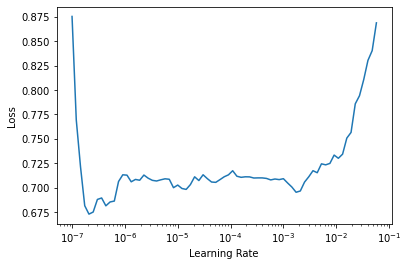

In [ ]:
#slow
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.713510,0.640587,0.630000,00:20
1,0.600469,0.591303,0.615000,00:19
2,0.492187,0.528877,0.795000,00:19


And here we creat a @typedispatched impelmentation of `Learner.show_results`.

In [ ]:
#export
@typedispatch
def show_results(x:HF_BaseInput, y, samples, outs, hf_tokenizer=None, ctxs=None, max_n=6, **kwargs):        
    
    if ctxs is None: ctxs = get_empty_df(min(len(samples), max_n))
    ctxs = show_batch[object](x, y, samples, max_n=max_n, ctxs=ctxs, **kwargs)
    
    n_preds_per_input = len(outs[0])
    if (n_preds_per_input == 1): 
        for i,ctx in enumerate(ctxs): ctx['target'] = outs[i][0]
    else:
        for pred_idx in range(n_preds_per_input):
            for i,ctx in enumerate(ctxs):  ctx[f'target{pred_idx+1}'] = outs[i][pred_idx]

    display_df(pd.DataFrame(ctxs))
    return ctxs

In [ ]:
learn.show_results(max_n=2)

,text,category,target
0,"This very funny British comedy shows what might happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of ancient documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><br />Stanley Holloway is excellent as the minor city politician who suddenly finds himself leading one of the world's tiniest nations. Dame Margaret Rutherford is a delight as the history professor who sides with Pimlico. Others in the stand-out cast include Hermione Baddeley, Paul Duplis, Naughton Wayne, Basil Radford & Sir Michael Hordern.<br /><br />Welcome to Burgundy!",positive,positive
1,"I am starting this review with a big giant spoiler about this film. Do not read further...here it comes, avert your eyes! The main heroine, the girl who always survives in other slasher films, is murdered here. There, I just saved you 79 minutes of your life.<br /><br />This is one of those cheap movies that was thrown together in the middle of the slasher era of the '80's. Despite killing the heroine off, this is just substandard junk.<br /><br />Both priests and college students get a bad rap here. They are pictured as oversexed, sociopathic morons who have way too many internal problems to deal with what looks like junior college campus life...and the college students come off even worse.<br /><br />""Splatter University"" is just gunk to put in your VCR when you have nothing better to do, although I suggest watching your head cleaner tape, that would be more entertaining.<br /><br />This is rated (R) for strong physical violence, gore, profanity, very brief female nudity, and sexual references.<br /><br />",negative,negative


In [ ]:
#export
@patch
def blurr_predict(self:Learner, item, rm_type_tfms=None, with_input=False):
    dl = self.dls.test_dl([item], rm_type_tfms=rm_type_tfms, num_workers=0)
    
    # this is where we have to change things up since a blurr "input" is represented by a dictionary of
    # tensors (input_ids, attention_mask, token_type_ids, etc...) and not a single tensor (which fastai assumes
    # in a number of places)
    b = dl.one_batch()
    inp = b[0]
    preds, _, dec_preds = self.get_preds(dl=dl, with_input=False, with_decoded=True)
    
    i = getattr(self.dls, 'n_inp', -1)
    inp = (inp,) if i==1 else tuplify(inp)
    dec = self.dls.decode_batch(inp + tuplify(dec_preds))[0]
    dec_inp,dec_targ = map(detuplify, [dec[:i],dec[i:]])
    res = dec_targ,dec_preds[0],preds[0]
    if with_input: res = (dec_inp,) + res
    return res

Same as with `summary`, we need to replace fastai's `Learner.predict` method with the one above which is able to work with inputs that are represented by multiple tensors included in a dictionary.

In [ ]:
learn.blurr_predict('I really liked the movie')

('positive', tensor(1), tensor([0.4140, 0.5860]))

In [ ]:
learn.unfreeze()

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.354436,0.245823,0.900000,00:51
1,0.155444,0.414681,0.870000,00:51
2,0.129245,0.284786,0.910000,00:51


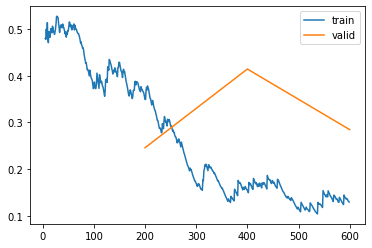

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(max_n=2)

,text,category,target
0,"This very funny British comedy shows what might happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of ancient documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><br />Stanley Holloway is excellent as the minor city politician who suddenly finds himself leading one of the world's tiniest nations. Dame Margaret Rutherford is a delight as the history professor who sides with Pimlico. Others in the stand-out cast include Hermione Baddeley, Paul Duplis, Naughton Wayne, Basil Radford & Sir Michael Hordern.<br /><br />Welcome to Burgundy!",positive,positive
1,"Sure this was a remake of a 70's film, but it had the suspense and action of a current film, say Breakdown. He's running, desperate to be with his hospitalized wife, the police are the least concern. The chases were very good, the part with him being<br /><br />cornered at a rest stop was well done, the end of the movie was a great cliffhanger. This is better than Bullitt, a boring movie with what, a muscle car chase that was filmed badly? Vigo's character knew what he had to do to escape Johnny Law, few movies had the effects-night vision, CB radio-okay I forgot the name of the movie, guy has 76'Caddy souped up, toys with guy he upset. The ending is great, you can't tell if he fakes his suicide or not, a very good did-he-make-it-or-not.",positive,positive


In [ ]:
learn.blurr_predict("This was a really good movie")

('positive', tensor(1), tensor([0.2031, 0.7969]))

In [ ]:
learn.blurr_predict("Acting was so bad it was almost funny.")

('negative', tensor(0), tensor([0.9958, 0.0042]))

And what about inference?

In [ ]:
learn.export(fname='seq_class_learn_export.pkl')

In [ ]:
inf_learn = load_learner(fname='seq_class_learn_export.pkl')
inf_learn.blurr_predict("This movie should not be seen by anyone!!!!")

('negative', tensor(0), tensor([0.9414, 0.0586]))

In [ ]:
inf_learn.blurr_predict("This movie should not be seen by anyone!!!!")

('negative', tensor(0), tensor([0.9414, 0.0586]))

## Example usage - Multi-label classification

Below demonstrates how to setup your `blurr` pipeline for a multi-label classification task

In [ ]:
# creates a dataset with the first 10% of training set
raw_data = nlp.load_dataset('civil_comments', split='train[:2%]') 
len(raw_data)

Using custom data configuration default


36097

In [ ]:
toxic_df = pd.DataFrame(raw_data)
toxic_df.head()

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
1,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
2,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
3,Is this something I'll be able to install on my site? When will you be releasing it?,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
4,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.0,0.87234,0.021277,0.0


In [ ]:
lbl_cols = list(toxic_df.columns[2:]); lbl_cols

['severe_toxicity',
 'obscene',
 'threat',
 'insult',
 'identity_attack',
 'sexual_explicit']

In [ ]:
toxic_df = toxic_df.round({col: 0 for col in lbl_cols})
toxic_df = toxic_df.convert_dtypes()

toxic_df.head()

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.000000,0,0,0,0,0,0
1,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.000000,0,0,0,0,0,0
2,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.000000,0,0,0,0,0,0
3,Is this something I'll be able to install on my site? When will you be releasing it?,0.000000,0,0,0,0,0,0
4,haha you guys are a bunch of losers.,0.893617,0,0,0,1,0,0


In [ ]:
toxic_df[toxic_df.identity_attack == 1].head(30)

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
31,Yet call out all Muslims for the acts of a few will get you pilloried. So why is it okay to smear an entire religion over these few idiots? Or is this because it's okay to bash Christian sects?,0.912500,0,0,0,1,1,0
534,So tired of all these Portlanders moving to California and ruining the culture. When will it stop?!?,0.700000,0,0,0,0,1,0
956,NIGGER,0.878788,0,0,0,1,1,0
2263,"Residence in our local county hoosegow will be quite educational for Bundy and his troops. There, they will meet lots of interesting people. We got black gangstas, and brown gangstas, methheads and assorted other felons.",0.600000,0,0,0,0,1,0
2473,It's real simple ...if you want wage rates to rise ....get rid of all of the illegal aliens currently keeping then artificially low,0.700000,0,0,0,0,1,0
2520,No more niqqers nips spics or Jews,0.785714,0,0,0,1,1,0
2974,"Every government is prone to tyranny unless those who are governed are diligently watchful over those who are given great power and are supposed to be serving them. This law subverts our ability to be watchful. Conflating the civil disobedience of a group who has to date never hurt or killed anyone with radical Muslim extremists is nonsense, and most certainly not the same thing. Would you have withheld Officer Darren Wilson's name from the violent and misinformed rioters in Ferguson? Quite frankly, he was in far more danger. The principles involved are of such importance that releasing t...",0.700000,0,0,0,0,1,0
4171,"The point is: Imago Dei has doctrines that are repugnant to me and other Portlanders. We hear the all-male ""Elders"" arguing for 1. female submission 2. unmarried households are living in sin 3. gay sex is sin. This is not a flawed doctrine- it is a homophobic misogynist doctrine that your evangelical church wants to spread. You are no different from a Santorum supporter except that the Santorum supporter is more honest and will not deny their church's doctrine.",0.600000,0,0,0,0,1,0
4969,"The comment about enslaving white people was rhetorical and affirmative action is not discrimination but reparation--payment for a debt. The white power structure consists of a bunch of super rich deadbeat racist thieves and murderers. Save your pop psychology billhooper, the dispossessed know how to make themselves ""feel better.""",0.600000,0,0,0,0,1,0
6342,"The Black one isn't a scientist, unlike her White counterparts. #Hollywoodsowhite",0.600000,0,0,0,0,1,0


In [ ]:
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = "roberta-base" # "distilbert-base-uncased" "bert-base-uncased"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(lbl_cols)

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Note how we have to configure the `num_labels` to the number of labels we are predicting. Given that our labels are already encoded, we use a `MultiCategoryBlock` with `encoded=True` and `vocab` equal to the columns with our 1's and 0's.

In [ ]:
# single input
blocks = (
    HF_TextBlock(hf_arch=hf_arch, hf_tokenizer=hf_tokenizer), 
    MultiCategoryBlock(encoded=True, vocab=lbl_cols)
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('text'), get_y=ColReader(lbl_cols), 
                   splitter=RandomSplitter())

In [ ]:
dls = dblock.dataloaders(toxic_df, bs=8)

In [ ]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([8, 512]), torch.Size([8, 6]))

In [ ]:
dls.show_batch(max_n=2)

,text,None
0,"""Pro corporate developer agenda""? ""Rampant development run amok""? (laughing) Perhaps you are thinking of Mike Clark, candidate for mayor, a Republican who is supported by larger development interests (as well as by Mr. Conte). Indeed, he was the only candidate for mayor who recently told the City Club of Eugene that he wanted to expand the urban growth boundary.\n\nBut all of the candidates for Ward 1—Mr. Anderson, Mr. Kelly, Ms. Semple, Mr. Skov and Mr. Wig—are fairly progressive. Still, you are of course free to vote for your candidate of choice. Just don't expect things to change if you vote for more of the same.",
1,"""e-Verify"" has existed since 1997 for employers to electronically screen job applicants for legal work status. But even in Arizona, where the State passed a law in 2008 to require its use, and even after that law was upheld by the US Supreme Court, it still isn't being used. And even in Arizona, no employer gets prosecuted for not using it.\n\nA law that isn't enforced is just words on paper.",


In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                loss_func=BCEWithLogitsLossFlat(),
                metrics=[partial(accuracy_multi, thresh=0.2)],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter)

learn.loss_func.thresh = 0.2
learn.create_opt()             # -> will create your layer groups based on your "splitter" function
learn.freeze()

Since we're doing multi-label classification, we adjust our loss function to use binary cross-entropy and our metrics to use the multi-label friendly version of accuracy.

In [ ]:
preds = model(b[0])
preds[0].shape

torch.Size([8, 6])

SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.0020892962347716093)

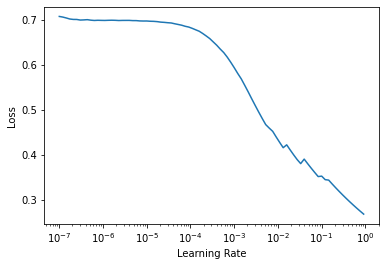

In [ ]:
#slow
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=3e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.037913,0.032807,0.993144,10:48
1,0.031415,0.028520,0.992613,10:48
2,0.031273,0.025932,0.992152,10:49


In [ ]:
learn.show_results(max_n=2)

,text,None,target
0,And you're another graduate of Wikipedia university. The Earth has been around how long? And scientists have been studying climate for how many years?,,[]
1,"no doubt, I have had kids come looking for work once. 35 years, once.\npathetic.",insult,[]


In [ ]:
learn.loss_func.thresh = 0.02

In [ ]:
comment = """
Those damned affluent white people should only eat their own food, like cod cakes and boiled potatoes. 
No enchiladas for them!
"""
learn.blurr_predict(comment)

((#1) ['insult'],
 tensor([False, False, False,  True, False, False]),
 tensor([6.7341e-07, 6.0355e-03, 1.1682e-03, 4.4684e-02, 1.0804e-02, 1.1852e-03]))

## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01a_data-language-modeling.ipynb.
Converted 01c_data-question-answering.ipynb.
Converted 01d_data-token-classification.ipynb.
Converted 01e_data-text-generation.ipynb.
Converted 02_modeling-core.ipynb.
Converted 02_training-summarization.ipynb.
Converted 02a_modeling-language-modeling.ipynb.
Converted 02c_modeling-question-answering.ipynb.
Converted 02d_modeling-token-classification.ipynb.
Converted 02e_modeling-text-generation.ipynb.
Converted index.ipynb.
